In [1]:
import os
import csv
import numpy as np

class Result:
    
    def __init__(self, name, age):
        self.name = name
        self.counts = dict()
        self.age = age
        self.read_length = 0
        self.mbases = 0
        self.snps = dict()
        self.coverage = 1
        
    def set_count(self, kmer_name, count):
        self.counts[kmer_name] = count
            
    def tel_count(self):
        return self.counts['TTAGGGTTAGGGTTAGGGTTAGGGT']
        
    def get_label(self):
        return "{}:{}, {}".format(self.name[7:], 
                              int(self.counts['GAGTCAAAAGCAGATACGTGTGTCA']), int(self.counts['GAGTCAAAAGCAGATACATGTGTCA']))
        
    def __str__(self):
        return 'Result {}, age: {}, {} | {}'.format(self.name, self.age, self.tel_count(), self.normalized_tel())
    
    def __repr__(self):
        return 'Result {}, age: {}, {} | {}'.format(self.name, self.age, self.tel_count(), self.normalized_tel())
        
                
                    
print "Starting..."
        
ages = dict()
read_lengths = dict()
mbases = dict()
with open('./static/SraRunTable.txt') as run_table:
    r = csv.reader(run_table, delimiter='\t')
    r.next()
    for row in r:
        ages[row[8]] = row[11]
        read_lengths[row[8]] = row[0]
        mbases[row[8]] = row[5]
        
def get_age(name):
    return int(ages[name])

def get_read_length(name):
    return int(read_lengths[name])

def get_mbases(name):
    return int(mbases[name])

def status():
    tot_m, used_m, free_m = map(str, os.popen('free -t -h').readlines()[-1].split()[1:])
    print used_m
    

print "Runtable OK!"
    
results = list()
k=1
for file in os.listdir('./files'):
    name = file[:-4]
    try:
        age = get_age(name)
    except:
        continue
    result = Result(name, age)
    result.read_length = get_read_length(name)
    result.mbases = get_mbases(name)
    with open('./files/'+file) as f:
        reader = csv.reader(f, delimiter='\t')  
        for row in reader:
            result.set_count(row[0], float(row[1]))
    results.append(result)
    f.close()
    k += 1
    if k%2000==0:
        status()
        #break

print "OK!"



Starting...
Runtable OK!
1.7G
2.5G
3.4G
4.2G
5.1G
OK!


<IPython.core.display.Javascript object>


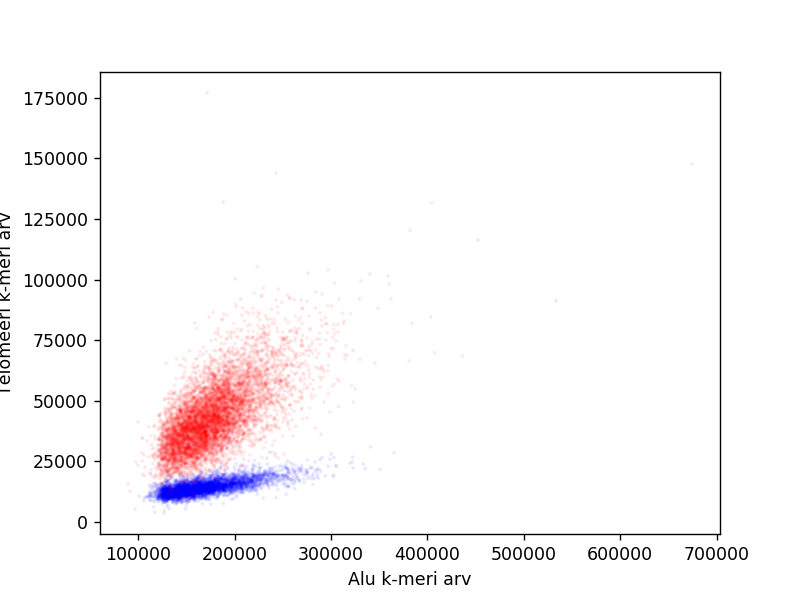

In [6]:
%matplotlib nbagg

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

tel_counts = map(lambda r: float(r.counts['TTAGGGTTAGGGTTAGGGTTAGGGT']), results)
#TTAGGGTTAGGGTTAGGGTTAGGGT

def count_alu(r):
    return r.counts['CTGTAATCCCAGCACTTTGGGAGGC']

alu_counts = map(count_alu, results)

plt.scatter(alu_counts,tel_counts ,s=2, alpha=0.05, c=map(lambda r: 'red' if int(r.read_length) is 166 else 'blue', results))

plt.ylabel('Telomeeri k-meri arv')

plt.xlabel('Alu k-meri arv')

plt.show()


<IPython.core.display.Javascript object>


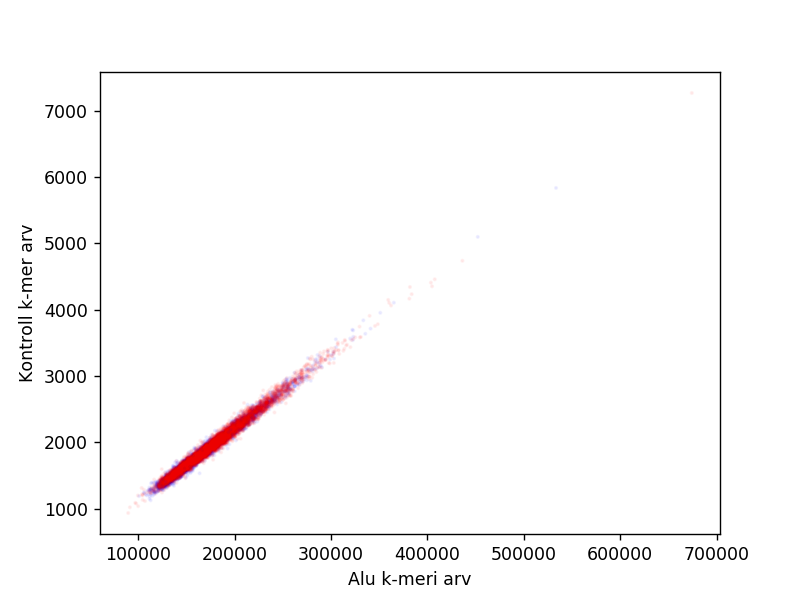

In [7]:
%matplotlib nbagg

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

other_alu = map(lambda r: float(r.counts['GTAGCTGGGATTACAGGCGTGTGCC']), results)
#TTAGGGTTAGGGTTAGGGTTAGGGT

def count_alu(r):
    return r.counts['CTGTAATCCCAGCACTTTGGGAGGC']

alu_counts = map(count_alu, results)
            
plt.scatter(alu_counts,other_alu ,s=2, alpha=0.05, c=map(lambda r: 'red' if int(r.read_length) is 166 else 'blue', results))

plt.xlabel('Alu k-meri arv')
plt.ylabel('Kontroll k-mer arv')

plt.show()


<IPython.core.display.Javascript object>


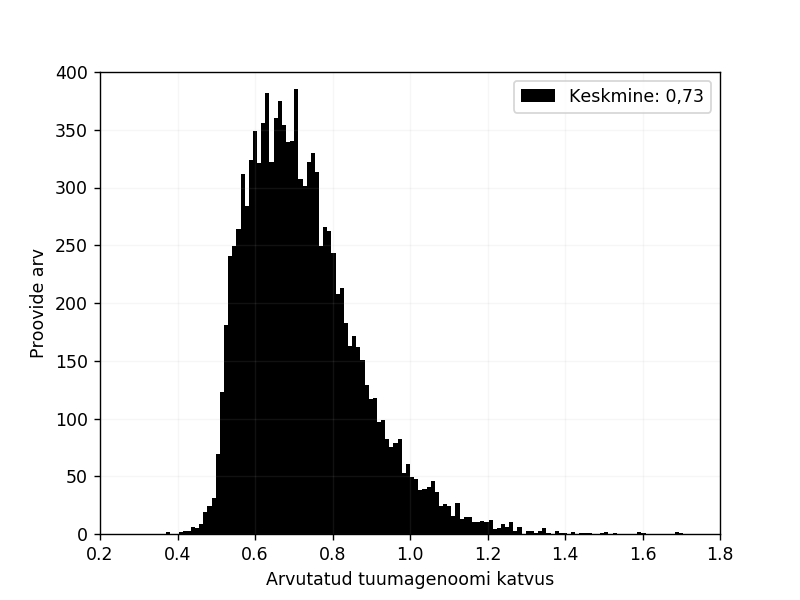

CTGTAATCCCAGCACTTTGGGAGGC esineb keskmiselt 
174265.991451
korda
CTGTAATCCCAGCACTTTGGGAGGC põhjal arvutatud katvus on seega
0.726992805625


In [12]:
%matplotlib nbagg

import math

buckets = 150
c = 22
main = 239708

d = 0
y2 = list(map(lambda r: d+(r.counts['CTGTAATCCCAGCACTTTGGGAGGC']/239708), results))
plt.hist(y2, buckets, range=(1.2-1.+d,2.8-1.+d), alpha=1,facecolor="black", label="Keskmine: "+str(round(np.average(y2),2)).replace('.',','))


print "CTGTAATCCCAGCACTTTGGGAGGC esineb keskmiselt "
print np.average(map(lambda r: float(r.counts['CTGTAATCCCAGCACTTTGGGAGGC']), results))
print "korda"

print "CTGTAATCCCAGCACTTTGGGAGGC põhjal arvutatud katvus on seega"
print np.average(map(lambda r: float(r.counts['CTGTAATCCCAGCACTTTGGGAGGC']), results))/239708.0


#plt.hist(c, 500, normed=1, alpha=0.5, facecolor="red")

plt.axis([1.2-1, 2.8-1, 0, 400])
plt.legend()
plt.xlabel('Arvutatud tuumagenoomi katvus')
plt.ylabel('Proovide arv')
plt.grid(alpha=0.1)
plt.show()

<IPython.core.display.Javascript object>


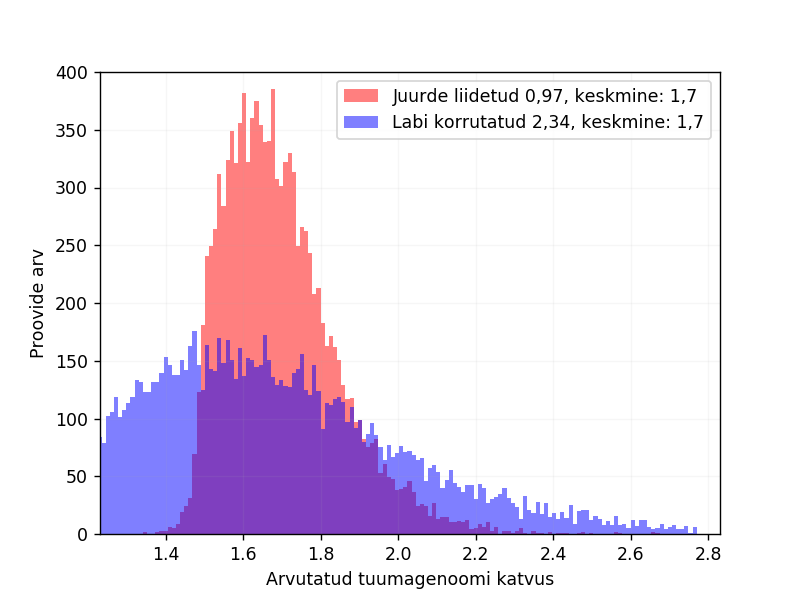

CTGTAATCCCAGCACTTTGGGAGGC esineb keskmiselt 
174265.991451
korda
CTGTAATCCCAGCACTTTGGGAGGC põhjal arvutatud katvus on seega
0.726992805625


In [8]:
%matplotlib nbagg

import math

buckets = 150
c = 22
main = 239708

d = .97
y2 = list(map(lambda r: d+(r.counts['CTGTAATCCCAGCACTTTGGGAGGC']/239708), results))
plt.hist(y2, buckets, range=(1.2-1.+d,2.8-1.+d), alpha=0.5,facecolor="red", label="Juurde liidetud 0,97, keskmine: "+str(round(np.average(y2),2)).replace('.',','))

y2 = list(map(lambda r: (r.counts['CTGTAATCCCAGCACTTTGGGAGGC']/239708)*2.34, results))
plt.hist(y2, buckets, range=(1.2-1.+d,2.8-1.+d), alpha=0.5,facecolor="blue", label="Labi korrutatud 2,34, keskmine: "+str(round(np.average(y2),2)).replace('.',','))


print "CTGTAATCCCAGCACTTTGGGAGGC esineb keskmiselt "
print np.average(map(lambda r: float(r.counts['CTGTAATCCCAGCACTTTGGGAGGC']), results))
print "korda"

print "CTGTAATCCCAGCACTTTGGGAGGC põhjal arvutatud katvus on seega"
print np.average(map(lambda r: float(r.counts['CTGTAATCCCAGCACTTTGGGAGGC']), results))/239708.0


#plt.hist(c, 500, normed=1, alpha=0.5, facecolor="red")

plt.axis([1.2-d+1, 2.8-d+1, 0, 400])
plt.legend()
plt.xlabel('Arvutatud tuumagenoomi katvus')
plt.ylabel('Proovide arv')
plt.grid(alpha=0.1)
plt.show()

Genoome pärast filtreerimist: 6863
Keskmine keskmine pikkus: 6850.99982752


<IPython.core.display.Javascript object>


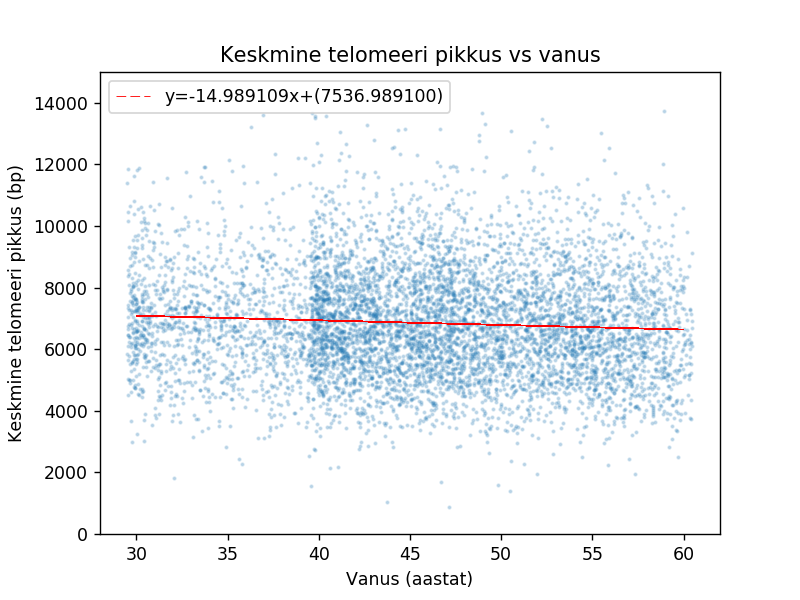

y=-14.989109x+(7536.989100)
6850.99982752
126668.441061


In [18]:
%matplotlib nbagg

import random

def get_coverage(r):
    return 0.97+(r.counts['CTGTAATCCCAGCACTTTGGGAGGC']/239708)

def calculate_avg_len(r):
    count = r.tel_count()
    coverage = get_coverage(r)
    return (count*25)/(coverage*92)

def get_x(r):
    return r.age+(random.random()-0.5) # shift the dot for cosmetic purposes

# filter the results
f_results = [r for r in results if int(r.read_length) is 166]
#f_results = results

print "Genoome pärast filtreerimist: "+ str(len(f_results))


x = list(map(get_x, f_results))
y = list(map(calculate_avg_len, f_results))

print "Keskmine keskmine pikkus: " + str(np.average(y))


labels = list(map(lambda r: r.get_label(), f_results))
plt.scatter(x, y, s=2, alpha=0.2)

true_x = map(lambda r: int(r.age), f_results)

z = np.polyfit(true_x, y, 1)
p = np.poly1d(z)
plt.plot(true_x,p(true_x),"r--", linewidth=0.5)
plt.legend( ["y=%.6fx+(%.6f)"%(z[0],z[1])])

plt.axis([28, 62, 0, 15000])
plt.xlabel('Vanus (aastat)')
plt.ylabel('Keskmine telomeeri pikkus (bp)')
plt.title("Keskmine telomeeri pikkus vs vanus")

plt.show()

print "y=%.6fx+(%.6f)"%(z[0],z[1])
print np.average(y)
print np.average([r.counts['TGTAATCCCAGCACTTTGGGAGGCC'] for r in f_results])

<IPython.core.display.Javascript object>


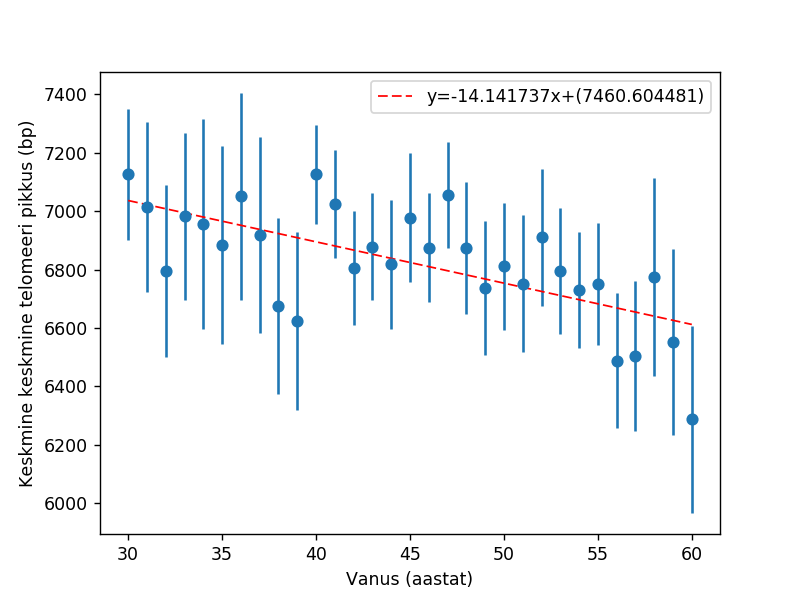

In [59]:
%matplotlib nbagg

import scipy.stats as ss


counts_by_age = dict()

for r in f_results:
    if r.age not in counts_by_age:
        counts_by_age[r.age] = list()
    counts_by_age[r.age].append(calculate_avg_len(r))
    
xg = range(30,61)

yg = [np.average(counts_by_age[a]) for a in xg]

cg = [st.t.interval(0.95, len(counts_by_age[a])-1, loc=np.mean(counts_by_age[a]), scale=st.sem(counts_by_age[a])) for a in xg]
#plt.scatter(xg, yg, s=2, alpha=1)

yerrups = [e[1]-np.average(counts_by_age[a+30]) for a,e in enumerate(cg)]
yerrdowns =  [np.average(counts_by_age[a+30]-e[0]) for a,e in enumerate(cg)]

plt.errorbar(xg, yg, yerr=[yerrups, yerrdowns],fmt='o')

z = np.polyfit(xg, yg, 1)
p = np.poly1d(z)
plt.plot(xg,p(xg),"r--", linewidth=1)
plt.legend( ["y=%.6fx+(%.6f)"%(z[0],z[1])])
plt.xlabel('Vanus (aastat)')
plt.ylabel('Keskmine keskmine telomeeri pikkus (bp)')

plt.show()